In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Loading the Monthly data

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the CSV file
file = "/content/SN_ms_tot_V2.0.csv"
df = pd.read_csv(file, sep=';', header=None)

# Naming the columns
df.columns = ['Year', 'Month', 'Fraction_Year', 'Sunspot_Number', 'Std_Dev', 'Observations', 'Indicator']

# Removing missing values
df = df.loc[df["Sunspot_Number"] != -1]

# Creating new DataFrame and copying required columns with the column names 'ds' (Date) and 'y' (Sunspot_Number)
df1 = pd.DataFrame()
df1['ds'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))  # Assume the first day of the month
df1['y'] = df['Sunspot_Number']

# Prepare DataFrame for Prophet
df_prophet = pd.DataFrame({'ds': df1['ds'], 'y': df1['y']})

# Convert 'ds' column to string format for compatibility and remove the time component
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.strftime('%Y-%m-%d')

# Splitting the DataFrame into train and test sets
df_train_prophet, df_data_test = train_test_split(df_prophet, test_size=0.2, shuffle=False)

# Output example
print(df_train_prophet.head())





            ds      y
6   1749-07-01  135.9
7   1749-08-01  137.9
8   1749-09-01  140.2
9   1749-10-01  143.8
10  1749-11-01  146.4


In [9]:
df_train_prophet.head()

,ds,y
6,1749-07-01,135.9
7,1749-08-01,137.9
8,1749-09-01,140.2
9,1749-10-01,143.8
10,1749-11-01,146.4


In [10]:
def prophet_model(df_train_prophet, df_data_test, growth='logistic', seasonality_mode='multiplicative', fourier_order=50,
                  changepoint_prior_scale=10, seasonality_prior_scale=10.0, holidays_prior_scale=10.0,
                  mcmc_samples=0, **kwargs):

    if growth=='logistic':
        # Using logistic growth
        df_train_prophet['cap'] = 0.95 * df_train_prophet['y'].max()
        df_train_prophet['floor'] = 1.05 * df_train_prophet['y'].min()

        model_prophet  = Prophet(growth=growth, seasonality_mode = seasonality_mode, changepoint_prior_scale=changepoint_prior_scale,
                                 seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale)
        model_prophet.add_seasonality(name='yearly', period=11*365, fourier_order=fourier_order)
        model_prophet.fit(df_train_prophet)

        df_future = model_prophet.make_future_dataframe(periods=df_data_test.shape[0], freq='MS')

        df_future['cap'] = 0.95 * df_train_prophet['y'].max()
        df_future['floor'] = 1.05 * df_train_prophet['y'].min()
        forecast_prophet = model_prophet.predict(df_future)
         #forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

        x_valid = df_data_test['y'].values
        results = forecast_prophet['yhat'].values[-df_data_test.shape[0]:]

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(x_valid, results))
        rmse = np.float64(rmse)

        # Compute the MAE
        mae_nn = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
        mae_nn = np.float64(mae_nn)

    return rmse, mae_nn

In [11]:
# Using logistic growth
df_train_prophet['cap'] = 0.95 * df_train_prophet['y'].max()
df_train_prophet['floor'] = 1.05 * df_train_prophet['y'].min()

model_prophet  = Prophet(growth='logistic', seasonality_mode='multiplicative', changepoint_prior_scale=25,
                         seasonality_prior_scale=0.25, holidays_prior_scale=1)
model_prophet.add_seasonality(name='yearly', period=11*365, fourier_order=50)

model_prophet.fit(df_train_prophet)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr89cky9h/uf55q3zr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr89cky9h/2eu3sr1h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71849', 'data', 'file=/tmp/tmpr89cky9h/uf55q3zr.json', 'init=/tmp/tmpr89cky9h/2eu3sr1h.json', 'output', 'file=/tmp/tmpr89cky9h/prophet_modelqh78qzo_/prophet_model-20241129164911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:49:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:49:19 - cmdstanpy - INFO - Chain [1] do

In [13]:
# Directory for neural network runs

import datetime
import os

current_dir = os.getcwd()
#if not os.path.exists(results_dir):
#    os.makedirs(results_dir)

results_dir = os.path.join(current_dir, 'results/prophet')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Generate a timestamp for the folder name
current_time = datetime.datetime.now()
folder_name = current_time.strftime("run_%Y-%m-%d_%H-%M-%S")

results_dir = os.path.join(results_dir, folder_name)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [14]:
df_future = model_prophet.make_future_dataframe(periods=df_data_test.shape[0], freq='MS')

df_future['cap'] = 0.95 * df_train_prophet['y'].max()
df_future['floor'] = 1.05 * df_train_prophet['y'].min()
forecast_prophet = model_prophet.predict(df_future)

forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
3250,2020-05-01,115.0,11.0,213.0
3251,2020-06-01,115.0,10.0,211.0
3252,2020-07-01,116.0,9.0,208.0
3253,2020-08-01,114.0,11.0,211.0
3254,2020-09-01,113.0,6.0,206.0


<Figure size 1000x600 with 0 Axes>

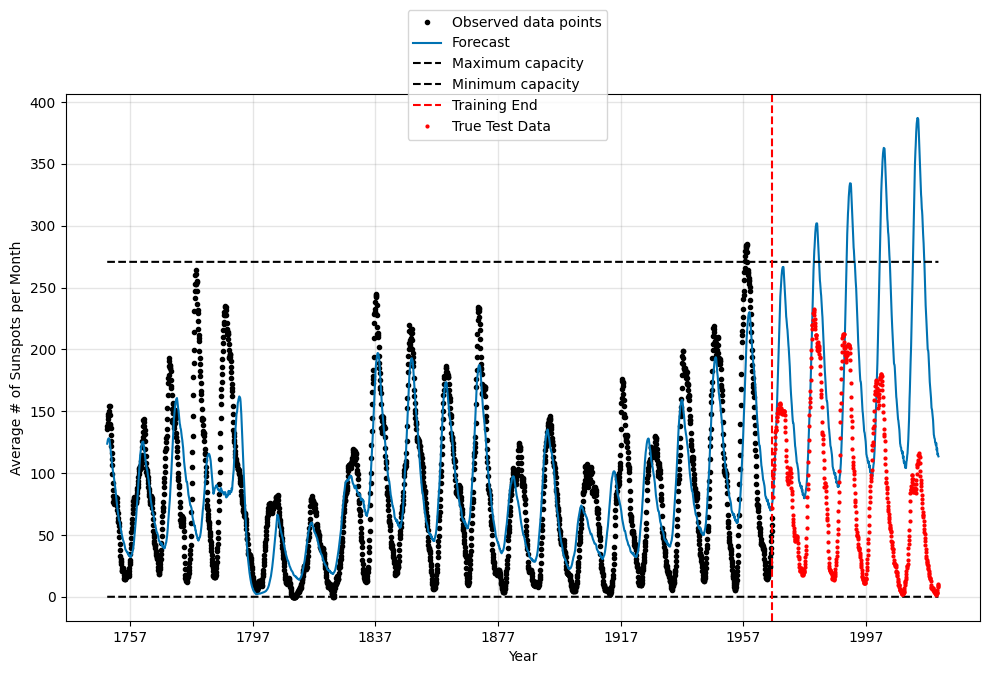

In [17]:
import matplotlib.pyplot as plt

# Ensure 'ds' is in datetime format for consistent plotting
df_data_test['ds'] = pd.to_datetime(df_data_test['ds'])

# Plot the time series
fig = plt.figure(figsize=(10, 6))

# Plot the forecast data
forecast_plot = model_prophet.plot(forecast_prophet, uncertainty=False)

# Add a vertical line at the end of the training period
axes = forecast_plot.gca()

# Change the axis labels
plt.xlabel("Year")
plt.ylabel("Average # of Sunspots per Month")

# Determine the last training date
last_training_date = forecast_prophet['ds'].iloc[-df_data_test.shape[0]]

# Add a vertical line at the training end
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# Plot true test data for the period after the red line
plt.plot(df_data_test['ds'], df_data_test['y'], 'ro', markersize=2, label='True Test Data')

# Show the legend to distinguish between the lines
plt.legend(bbox_to_anchor=(0.6, 0.9))

# Save the plot as a file
forecast_plot.savefig(results_dir + '/predictions.png', dpi=600, format='png', bbox_inches='tight')

# Display the plot
plt.show()


In [ ]:
# Evaluate using proper y_true and y_pred alignment
y_true = df1['y']
y_pred = forecast_daily['yhat'][:len(y_true)]

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}, R²: {r2:.3f}")

MAE: 40.37, MAPE: 3.34, R²: 0.519
